# IGRINS Data Reduction: Raw Data to PCA

## Full tutorial based on the IGRINS_transit code found at https://github.com/meganmansfield/IGRINS_transit
### This code is currently under heavy development, but the tutorial included here, which can also be found on the GitHub page, will take you from raw data to a principal component analysis. Future updates will include cross-correlation analysis. This tutorial follows the process outlined in run_pipeline.py
### NOTE: This tutorial is based on as-yet-unpublished data. Please do not share the data/results without permission.
### First, let's load the analysis packages

In [43]:
import numpy as np
import make_cube #makes the data cube and calculates barycentric velocity
import wavecal #performs wavelength calibration
import do_pca #performs principal component analysis
import trail #make "trail" plot showing path of planet through orbit
import CCF_transmission #make "blob" plot showing cross-correlation with model template as a function of systemic and Keplerian velocities
from astropy.io import fits
import CCF_emission

### Now feed the code all the important parameters.

In [44]:
path='../../plp/outdata/20240721/' #path to the reduced data provided by the IGRINS pipeline package (PLP)
date='20240721' #date of the observations (just used to name folders)
Tprimary_UT='2024-07-22T07:22:00.000' #time of primary transit, which can be found using the Transit and Ephemeris Service tool at https://exoplanetarchive.ipac.caltech.edu/
Per=5.633467850 #in days, also from Exoplanet Archive or your favorite planet lookup service
T14=4.248 #Transit duration, in hours, also from the Exoplanet Archive
radeg=245.1514916666667 #in degrees
decdeg=41.048086111111104 #in degrees
exptime=90. #in seconds
#note that RA and Dec must be in degrees; here's a helpful converter: http://www.astrouw.edu.pl/~jskowron/ra-dec/
skyorder=1 #set to 1 if the sky frame was observed at the start of the night and 2 if the sky frame was observed at the end of the night
Vsys=-0.22 #Systemic radial velocity in km/s, listed as "gamma" on the Exoplanet Archive
Kp=184 #Planet's Keplerian velocity, in km/s. Can be calculated from the radial velocity semi-amplitude ("K" on the Exoplanet archive) through: Kp=K*Mstar/Mp
vsini=1.5 #Planet's rotational velocity, calculate based on Keplerian velocity
model=np.loadtxt('//Users/cicero/Documents/projects/ig2-commission/SV Analysis/HAT-P-2b-model-emissionFlux.txt') #Path to the model for the atmosphere that we'll use for cross-correlation later
badorders=np.array([0, 21, 22, 23, 24, 25, 26, 27, 52]) #set which orders will get ignored. Lower numbers are at the red end of the spectrum, and IGRINS has 54 orders
trimedges=np.array([100,-100]) #set how many points will get trimmed off the edges of each order: fist number is blue edge, second number is red edge

In [45]:
import astropy.units as u

In [46]:
Kp_test = 930*u.m/u.s* 1.6* u.M_sun/(9*u.M_jupiter)

In [47]:
Kp_test.to(u.km/u.s)

<Quantity 173.19749842 km / s>

### Now we'll set a couple parameters for trimming the data. I usually start with keeping as much data as possible and looking at the SNR before throwing any out.

In [48]:
# badorders=np.array([0, 21, 22, 23, 24, 25, 26, 27, 52]) #set which orders will get ignored. Lower numbers are at the red end of the spectrum, and IGRINS has 54 orders
# trimedges=np.array([100,-100]) #set how many points will get trimmed off the edges of each order: fist number is blue edge, second number is red edge

### Now we're ready to make our data cube! This function will take in the raw data files and output a cube of data organized by order x file (phase of orbit) x pixels. It also outputs the observed phases and barycentric velocity at each exposure time.

In [49]:
tt = fits.open(path+'SDCH_20240721_0010.spec.fits')

In [50]:
tt

[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x14c63cef0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x14c9d0140>]

Making data cube...
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
ERROR: H and K files are misaligned
Calculating observed phases...
Calculating barycentric velocity...
Mean barycentric velocity during observation period is 13.393 km/s
Orders with SNR<100:  []
Orders with 100<SNR<200:  []
Orders with <70\% transmittance:  [0, 1, 18, 43]


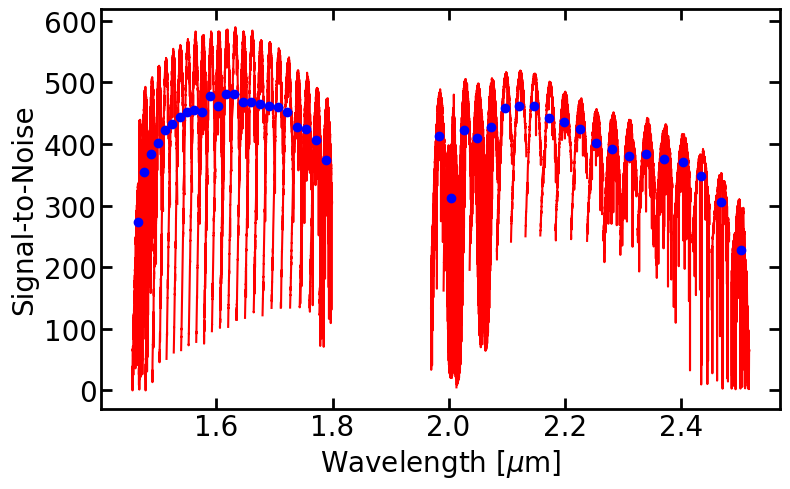

Cleaning data and removing unwanted orders...


In [51]:
phi,Vbary,grid_RAW,data_RAW,wlgrid,data=make_cube.make_cube(path,date,Tprimary_UT,Per,radeg,decdeg,skyorder,exptime,badorders,trimedges,plot=True,output=False,testorders=True)
#testorders=True will output some information on the SNR of all the orders.
#plot=True will plot the SNR over each order
#output=True will save 3 pickle files for future data processing (not necessary if you stay within this pipeline, but useful if you want to port information to your own data analysis process):
#phi.pic has observed phases
#Vbary.pic has barycentric velocities
#data_raw_OBSDATE.pic has [wavelength grid, raw data (no orders removed), skyorder parameter]

In [52]:
phi

array([-0.00901229, -0.00844977, -0.00788667, -0.00732359, -0.00676079,
       -0.00619804, -0.00563584, -0.00507346, -0.00451108, -0.00394853,
       -0.0033856 , -0.0028233 , -0.00225797])

In [53]:
np.shape(data_RAW)

(53, 13, 2048)

In [54]:
# plt.plot(data[42,0,:])

### Now we have to perform a wavelength calibration. The function here just assumes the image taken closest to the sky calibration has "true" wavelengths and does a simple shift/stretch to fit each subsequent spectrum to the template spectrum.

In [55]:
skyorder

1

Performing wavelength calibration...


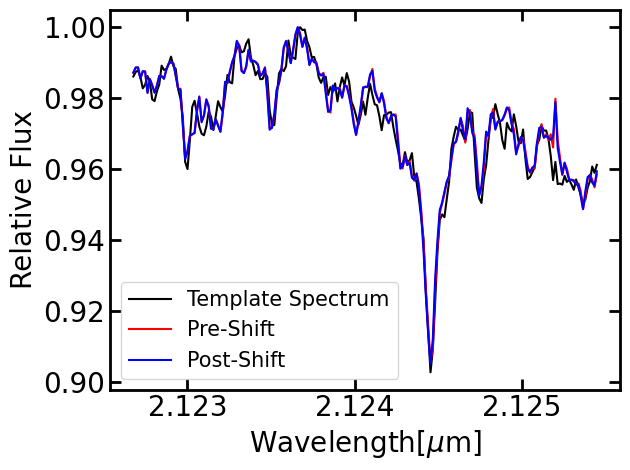

In [56]:
wlgrid,wavecorrect=wavecal.correct(wlgrid,data,skyorder,plot=True,output=False)
wavecorrect += 1e-19
#plot=True will plot a zoom-in on one of the orders so you can see the results of the wavelength calibration and check them by eye
#output=True will save a file called wavelengthcalibrated.pic that contains [wavelength array, wavelength calibrated data cube]

In [57]:
# wlgrid

In [58]:
# wavecorrect

In [59]:
np.min(wavecorrect)

-0.16655429826087043

### Now we can perform a principal component analysis! 

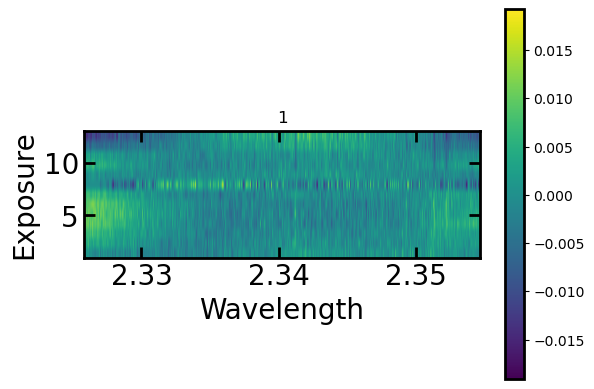

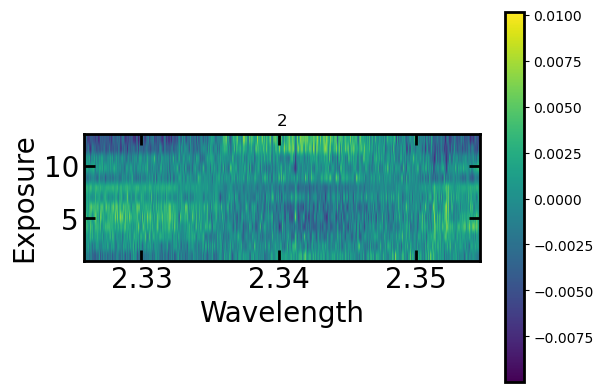

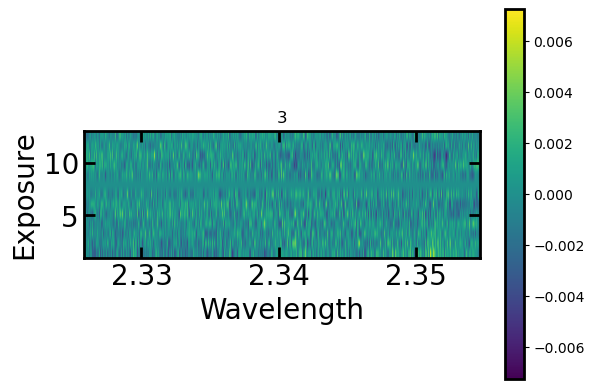

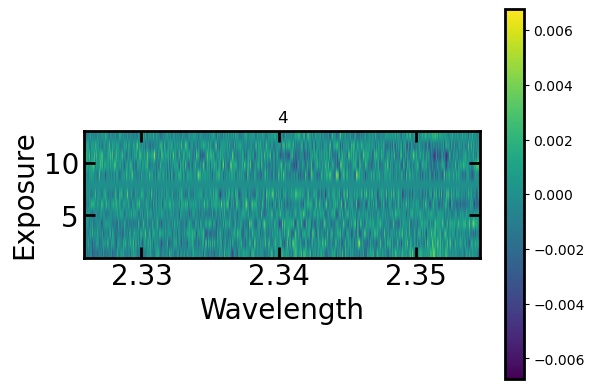

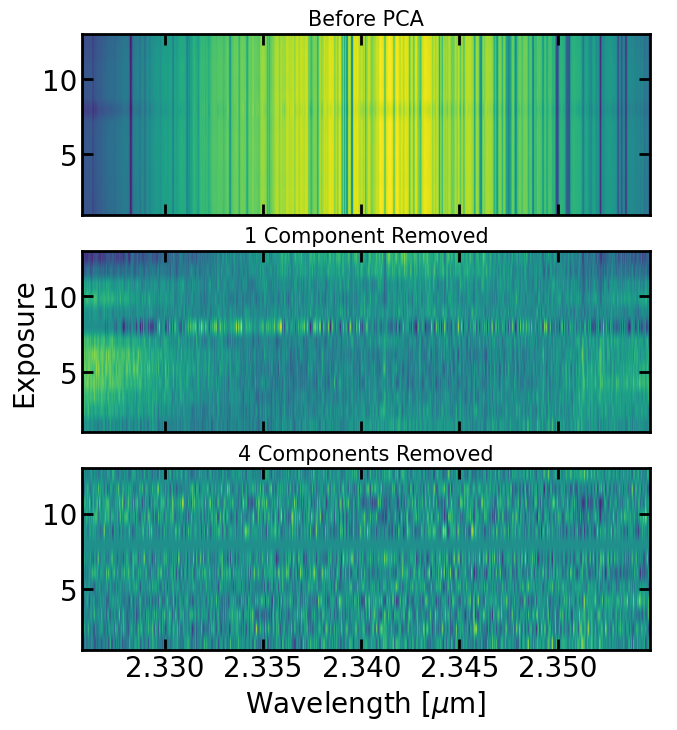

In [60]:
nPCAs=4 #number of principal components to subtract (or maximum value for test_pca)
wlgrid,pca_clean_data,pca_noplanet=do_pca.do_pca(wlgrid,wavecorrect,nPCAs,plot=True,output=True)
#test_pca=True will go through removing every number of PCs from 1 to nPCAs, plotting the cleaned results each time
#plot=True will show a plot comparing the raw data, data with 1 PC removed, and data with nPCAs removed
#output=True will save two pickle files:
#PCA_n_clean_data.pic contains [wavelength array, cleaned data] where cleaned data have n PCs removed
#PCA_n_noise.pic contains [wavelength array, removed noise] where removed noise is all the signal contained in the first n PCs

In [61]:
np.nanmax(pca_clean_data)

0.009905752893349528

In [62]:
np.nanmin(pca_clean_data)

-0.009888520819446741

In [63]:
import matplotlib.pyplot as plt

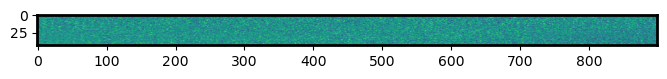

In [64]:
plt.figure(figsize=(8, 6))
plt.imshow(pca_clean_data[:,0,500:1400])
plt.show()

### Now we'll make two plots using cross-correlation with a model template to visualize the detection of the planet's atmosphere. First, a "trail" plot, which shows velocity as a function of phase.

In [65]:
import trail #make "trail" plot showing path of planet through orbit

In [66]:
Kp

184

In [67]:
print(phi, Kp*np.sin(phi))

[-0.00901229 -0.00844977 -0.00788667 -0.00732359 -0.00676079 -0.00619804
 -0.00563584 -0.00507346 -0.00451108 -0.00394853 -0.0033856  -0.0028233
 -0.00225797] [-1.65823898 -1.55473962 -1.45113261 -1.34752805 -1.24397504 -1.1404325
 -1.03698839 -0.93351257 -0.83003548 -0.72652814 -0.62294847 -0.51948648
 -0.41546621]


In [68]:
Vsys + Vbary + Kp*np.sin(2.*np.pi*phi) 

array([ 2.71795234,  3.37409948,  4.03106454,  4.68813907,  5.34500097,
        6.00190023,  6.65826807,  7.31491956,  7.97165113,  8.62863626,
        9.28613136,  9.94291994, 10.60328256])

Calculating trail...
Note: trail may take a while to compute. Turn on verbose to get updates on the status of the calculation.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


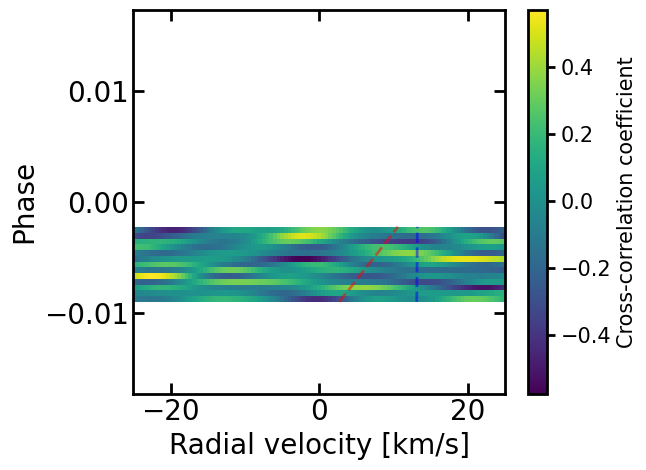

In [69]:
scale=1.
trail_CCF, vel=trail.trail(wlgrid,pca_clean_data,pca_noplanet,model, phi,Vbary,Kp,Vsys,scale,Per,T14,vsini,verbose=True)
#verbose=True will print updates on the trail plot as it calculates

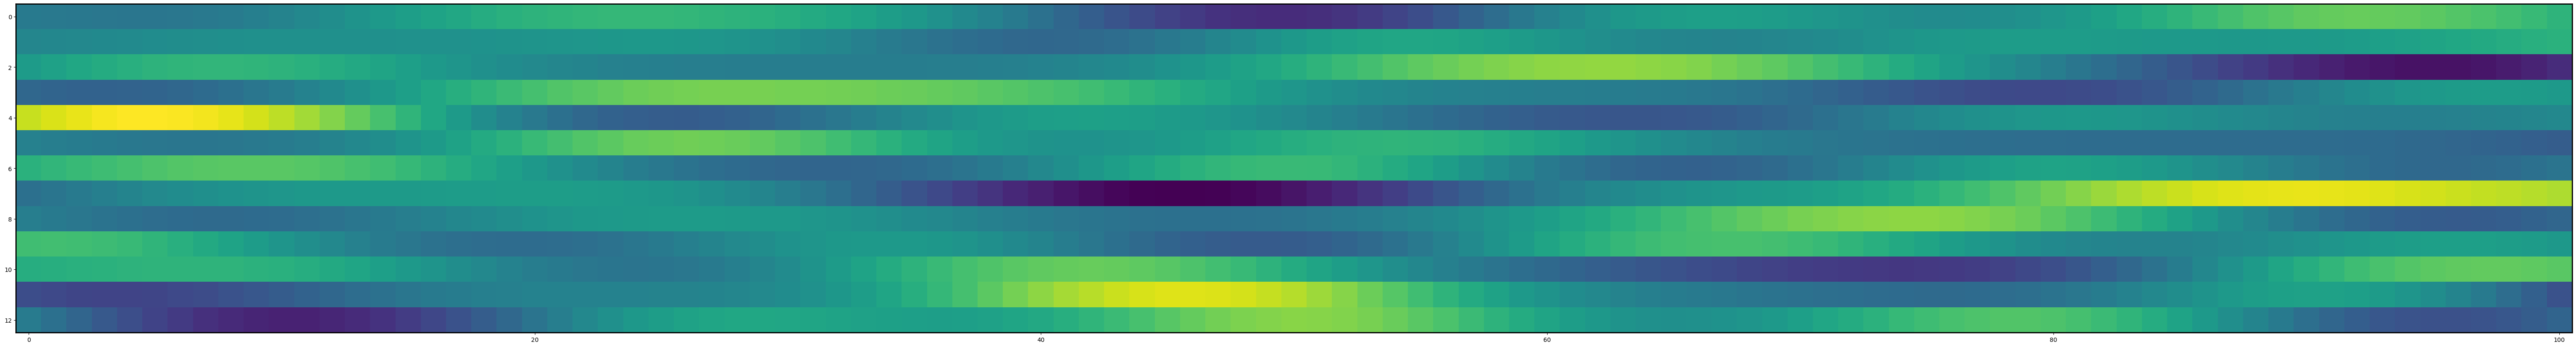

In [70]:
plt.figure(figsize=(100, 10))
plt.imshow(trail_CCF)
plt.show()

In [71]:
np.deg2rad(phi)

array([-1.57294140e-04, -1.47476350e-04, -1.37648394e-04, -1.27820715e-04,
       -1.17997966e-04, -1.08176247e-04, -9.83638991e-05, -8.85485755e-05,
       -7.87331590e-05, -6.89148968e-05, -5.90897973e-05, -4.92758779e-05,
       -3.94090190e-05])

In [72]:
vel.min(),vel.max(),phi.min(),phi.max()

(-25.0, 25.0, -0.009012290366277754, -0.0022579704642602)

In [73]:
np.shape(trail_CCF)

(13, 101)

In [74]:
trail_CCF

array([[-0.10925222, -0.11411023, -0.11894177, ...,  0.22184253,
         0.19601751,  0.16895991],
       [-0.05073165, -0.04600892, -0.04003053, ...,  0.13478827,
         0.1467469 ,  0.15723997],
       [ 0.0510858 ,  0.07894665,  0.10507952, ..., -0.48772019,
        -0.46187081, -0.42939203],
       ...,
       [ 0.13915454,  0.14459634,  0.15092354, ...,  0.29409843,
         0.2875305 ,  0.27647289],
       [-0.30432893, -0.32235992, -0.3346213 , ..., -0.16550737,
        -0.22554045, -0.28723645],
       [-0.09828878, -0.15115354, -0.20325365, ..., -0.26437102,
        -0.23862206, -0.20618922]])

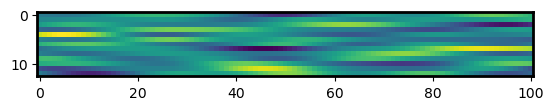

In [75]:
plt.figure()
plt.imshow(trail_CCF)
plt.show()

In [76]:
# plt.figure()
# plt.imshow(trail_CCF,origin='lower', extent=[vel.min(),vel.max(), phi.min(),phi.max()],aspect='auto',interpolation='none')
# plt.show()

### Finally, a "blob" plot, which shows the systemic velocity (Vsys) vs. the planetary Keplerian velocity (Kp). You can think of this as combining the smeared out planet detection from the "blob" plot into a single point.
#### Important note: The cross-correlation calculation we're doing here is designed for planets during transit. The calculation is slightly different for looking at planetary emission not during transit. Ask me if you'd like to know how to use the code for emission!

In [77]:
Kp

184

Calculating cross-correlation...
Note: this calculation may take several hours to complete on a normal computer.
Kp step:0
Kp step:1
Kp step:2
Kp step:3
Kp step:4
Kp step:5
Kp step:6
Kp step:7
Kp step:8
Kp step:9
Kp step:10
Kp step:11
Kp step:12
Kp step:13
Kp step:14
Kp step:15
Kp step:16
Kp step:17
Kp step:18
Kp step:19
Kp step:20
Kp step:21
Kp step:22
Kp step:23
Kp step:24
Kp step:25
Kp step:26
Kp step:27
Kp step:28
Kp step:29
Kp step:30
Kp step:31
Kp step:32
Kp step:33
Kp step:34
Kp step:35
Kp step:36
Kp step:37
Kp step:38
Kp step:39
Kp step:40
Creating cross-correlation plot...
Maximum detection significance: 2.2455061748739236. Maximum detection at Vsys=-16.6, Kp=144.0


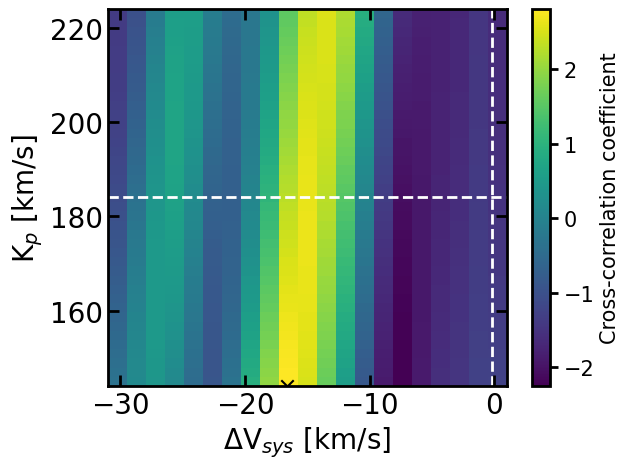

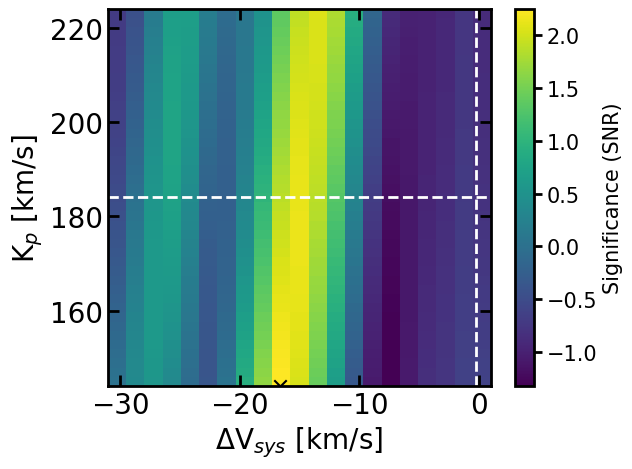

In [78]:
Kstar=-20.4 #in km/s
Rp=0.951 * 7.15*10**7 #in m
Rstar=1.46* 7*10**8 #in m 1.46 R_sun

CCFarr=CCF_emission.run_CCF(wlgrid,pca_clean_data,pca_noplanet,model,phi,Vbary,Kp,Vsys,Kstar,\
                            scale,nPCAs,vsini,Rp,Rstar,name='HAT-P-2b',output=False,verbose=True,
                           vsys_baseline = 30, 
                            vsys_hi = 1, 
                            kp_baseline = 40, 
                            kp_hi = 40,
                            kparr_steps =41, vsys_steps =21
                           )


In [79]:
# CCFarr=CCF_transmission.run_CCF(wlgrid,pca_clean_data,pca_noplanet,model,phi,Vbary,Kp,Vsys,scale,nPCAs,Per,T14,vsini,name='HAT-P-2b',output=False,verbose=True)
#verbose=True will again print updates on the cross-correlation as it calculates. Note this calculation can take a long time!
#output=True will save a pickle file containing the Vsys array, Kp array, CCF arrray, and log likelihood array
#NOTE: For the purposes of this tutorial running quickly, I've limited the range of Kp and Vsys values that are explored by the CCF.
#When analyzing actual data, you should ALWAYS search a wide grid of Kp and Vsys values (I recommend Vsys from -50 to +50 and Kp from -(a bit more than your planet signal) to +(a bit more than your planet signal) - i.e., if you expect Kp=150 search from -200 to +200.)
#To change the number of Kp and Vsys values investigated, edit lines 89-90 in the file CCF_transmission.py


In [80]:
phi*2*np.pi

array([-0.05662589, -0.05309149, -0.04955342, -0.04601546, -0.04247927,
       -0.03894345, -0.035411  , -0.03187749, -0.02834394, -0.02480936,
       -0.02127233, -0.01773932, -0.01418725])

In [81]:
phi.min(),phi.max()

(-0.009012290366277754, -0.0022579704642602)